In [24]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

В baseline были использованы классические **модели** машинного обучения:
- `Логистическая регрессия` - применяется для прогнозирования вероятности возникновения некоторого события по значениям множества признаков $P\{y=1|x\}=\dfrac{1}{1+exp(-x \times w)}$
- `Метод опорных векторов` - испоьзует идею перевода исходных векторов в пространство более высокой размерности и поиска разделяющей гиперплоскости с наибольшим зазором в этом пространстве, причем две параллельных гиперплоскости строятся по обеим сторонам гиперплоскости, разделяющей классы $a(x)=sign(\sum_{i=0}^{n} \lambda_{i} c_{i} x_{i} \times x - b)$
- `Градиентный бустинг` - строит модель предсказания в форме ансамбля слабых предсказывающих моделей, обычно деревьев решений, затем следующая модель, которая будет добавлена в ансамбль будет предсказывать эти отклонения, тем самым уменьшая среднее отклонение модели $L_{\theta}(\tilde\theta)=\sum_{i=1}^{N} L(y_{i}, f(x_{i}, \tilde\theta))$
- `Случайный лес` - заключается в построении путем *bootstrap aggregation* ансамбля решающих деревьев каждое из которых само по себе даёт очень невысокое качество классификации, но за счёт их большого количества результат получается приемлимым
- `Байесовский классификатор` - вероятностный классификатор, основанный на применении теоремы Байеса со строгими, и в тоже время наивными предположениями о независимости $P(C|F_{1}, ..., F_{n})=\dfrac{p(C)p(F_{1}, ..., F_{n}|C)}{p(F_{1}, ..., F_{n})}$

В качестве **метрик** использовались:
- `Доля правильно предсказанных классов`, данная метрика хорошо интерпретируема, однако неустойчива к дисбалансу классов $Accuracy=\dfrac{TP+TN}{TP+TN+FP+FN}$
- `Точность` - доля правильно предсказанных положительных объектов среди всех объектов, которые были предсказаны как положительные $Precision=\dfrac{TP}{TP+FP}$ и `Полнота` - доля правильно найденных положительных объектов среди всех объектов положительного класса $Recall=\dfrac{TP}{TP+FN}$, которые являются устойчивыми к дисбалансу в корпусе
- `F-мера` - среднее гармоническое Precision-Recall, является сглаженной версией функции минимума от них $F_{\beta}=(\beta^2 + 1)\dfrac{Precision \times Recall}{\beta^2 Precision \times Recall}$ 
- `Матрица ошибок` - представляет из себя таблицу со значениями  *true positive (TP) false positive (FP) true negative (TN) false negative (FN)*
- `ROC-AUC` - позволяет оценить работу модели в зависимости от порога классификации, значение AUC равно доле пар объектов вида 1 и 0, которые алгоритм верно упорядочил, и данную метрику следует использовать в случае, когда важен порядок объектов, однако данная метрика не устойчива при сильном дисбалансе $AUC=\dfrac{\sum_{i=1}^{N}\sum_{j=1}^{N}\mathbb{I}[y_{i}<y_{j}]I^ \prime[f(x_{i})<f(x_{j})]}{\sum_{i=1}^{N}\sum_{j=1}^{N}\mathbb{I}[y_{i}<y_{j}]}$ 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/800px-Precisionrecall.svg.png" alt= “” width="30%" height="10%">

In [2]:
def load_file(path):
    with open(path, 'rb') as f:
        arr = np.load(f)
    return arr

In [17]:
df = pd.read_csv('saved/dataset_with_audio.csv')
audio_clf_df = all_df.dropna()
text_clf_df = df.copy()

In [62]:
def models_fit(X_train, y_train):
    
    classify_models = [
    LogisticRegression(penalty='l2', C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, solver='lbfgs'),
    SVC(C=1.0, kernel='rbf', cache_size=200, class_weight=None, probability=True),
    GradientBoostingClassifier(loss='log_loss', learning_rate=0.1, n_estimators=100, criterion='friedman_mse'), 
    RandomForestClassifier(n_estimators=100, criterion='gini', bootstrap=True, oob_score=False), 
    BernoulliNB()
    ]

    classify_names = [
        'LogisticRegression',
        'SVC',
        'GradientBoostingClassifier',
        'RandomForestClassifier',
        'BernoulliNB'
    ]

    for i, (m, n) in enumerate(zip(classify_models, classify_names)):
        model = m
        model.fit(X_train, y_train)
        print(f'{n} is fitted')
    
    return classify_models, classify_names


def metrics_plot(classify_models, classify_names, metric):
    
    sns.set(font_scale=1.2)
    
    if metric == 'classification_report': _, ax = plt.subplots(1, 5, figsize=(23, 3), sharey=True)
    if metric == 'roc-auc': _, ax = plt.subplots(1, 5, figsize=(24, 3), sharey=True)
    if metric == 'confusion_matrix': _, ax = plt.subplots(1, 5, figsize=(24, 3), sharey=True)
    
    for i, (m, n) in enumerate(zip(classify_models, classify_names)):
        
        if metric == 'classification_report':
            sns.heatmap(pd.DataFrame(classification_report(y_test, m.predict(X_test), output_dict=True)).T,
                            annot=True, ax=ax[i])
        if metric == 'roc-auc':
            plot_roc_curve(y_test, m.predict_proba(X_test), ax=ax[i])
        
        if metric == 'confusion_matrix':
            plot_confusion_matrix(y_test, m.predict(X_test), ax=ax[i], normalize='true')
            ax[i].grid(False)
            
        ax[i].set_title(f'{n}')

### Fasttext

В качестве текстового представления вместо `tf-idf` и `bag of words` были выбраны более плотные представления, которые содержат семантическую информацию и повышают производительность моделей машинного обучения. `FastText` для векторных представлений слов использует skip-gram с негативным сэмплированием с добавлением subword-модели (представление слова через цепочки символов), что позволяет учитывать составные слова.

In [3]:
text = load_file('saved/fasttext_train.npy')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(text, text_clf_df.sentiment_2, test_size=.2, random_state=2023)

X_train.shape, y_train.shape

((13019, 500), (13019,))

In [29]:
classify_models, classify_names = models_fit(X_train, y_train)

LogisticRegression is fitted
SVC is fitted
GradientBoostingClassifier is fitted
RandomForestClassifier is fitted
BernoulliNB is fitted


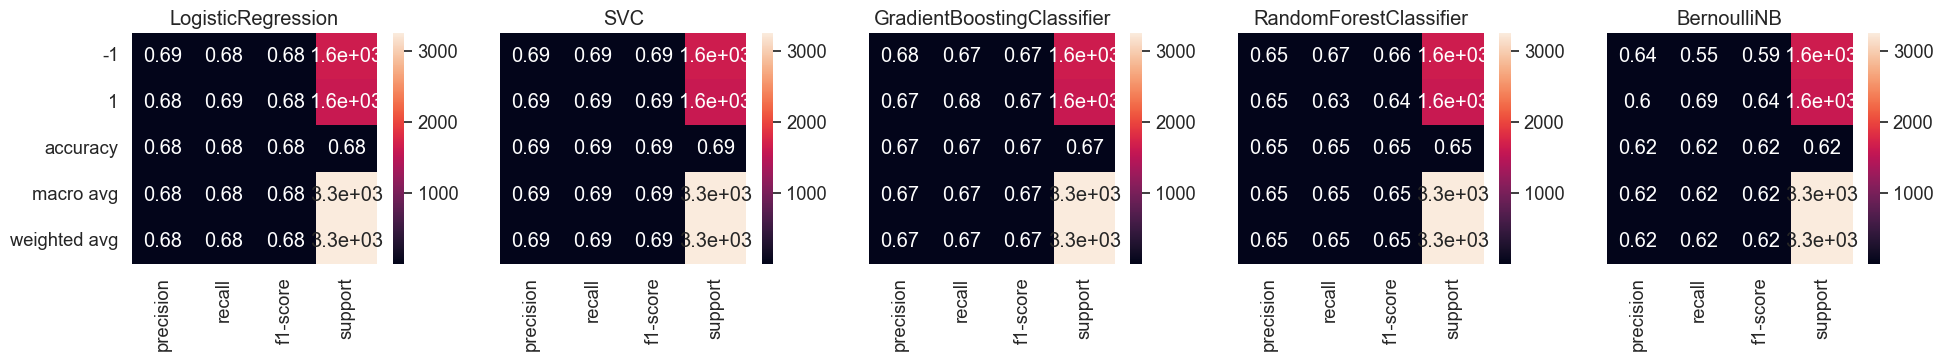

In [53]:
metrics_plot(classify_models, classify_names, 'classification_report')

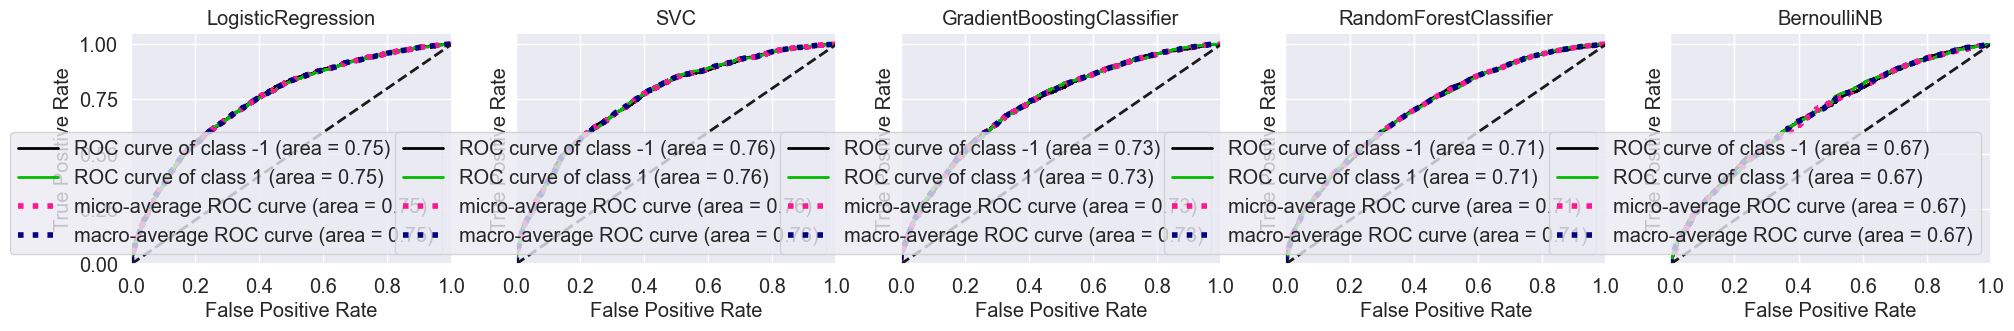

In [60]:
metrics_plot(classify_models, classify_names, 'roc-auc')

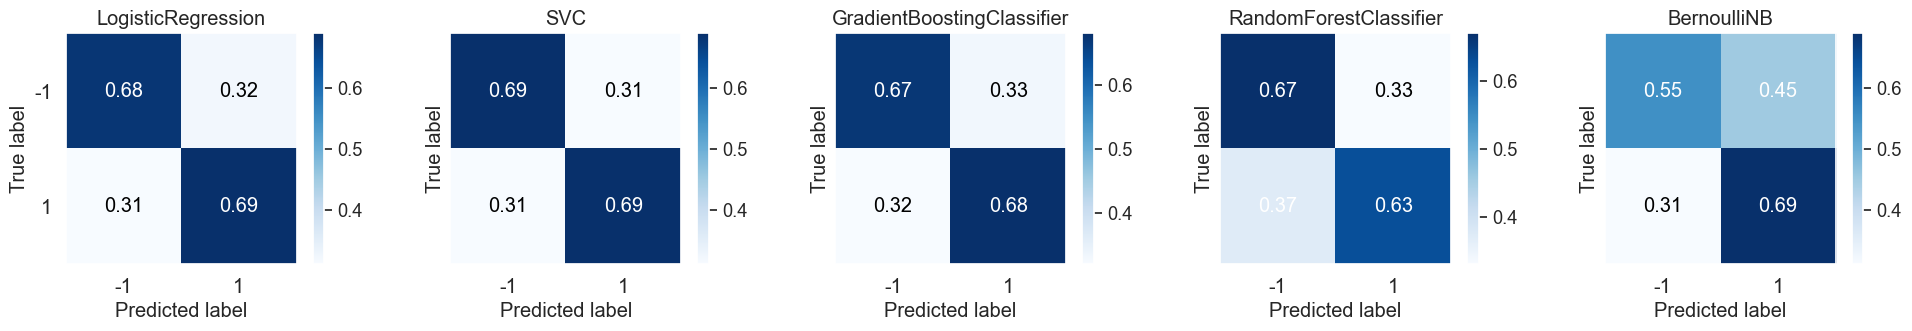

In [63]:
metrics_plot(classify_models, classify_names, 'confusion_matrix')

### BERT

Языковая модель `BERT` состоит из стека кодирующих слоев `Transformer` и использует механизм внимания, который изучает контекстуальные отношения между словами (или подсловами) в тексте. BERT считывает сразу всю последовательность слов, и поэтому он считается двунаправленным и эта особенность позволяет модели изучать контекст слова на основе всего его окружения (слева и справа от слова). Для этого BERT использует специальную технику обучения:
- Перед вводом последовательности слов в BERT 15% слов в каждой последовательности заменяется токеном [MASK]. Затем модель пытается предсказать исходное значение замаскированных слов на основе контекста, предоставляемого другими, не замаскированными словами в последовательности $$\sum_{S}\sum_{i \in M(S)}ln(p(w_{i}|i, S, W)) \to \max_{W}$$
- В рамках процесса обучения BERT модель в качестве входных данных получает пары фраз, на которых она учится предсказывать, является ли вторая фраза в паре следующей после первой в исходном тексте. Во время обучения 50% входных данных представляют собой пары, в которых вторая фраза действительно является следующей фразой в исходном тексте, а в остальных 50% в качестве второй фразы выбирается случайная фраза из того же текста. Предполагается, что случайная фраза будет не связана по смыслу с первой фразой $$\sum_{SS^\prime}ln(p(y_{SS^\prime})|S,S^\prime,W)$$

In [64]:
text = load_file('saved/bert_train.npy')
X_train, X_test, y_train, y_test = train_test_split(text, text_clf_df.sentiment_2, test_size=.2, random_state=2023)

In [65]:
classify_models, classify_names = models_fit(X_train, y_train)

LogisticRegression is fitted
SVC is fitted
GradientBoostingClassifier is fitted
RandomForestClassifier is fitted
BernoulliNB is fitted


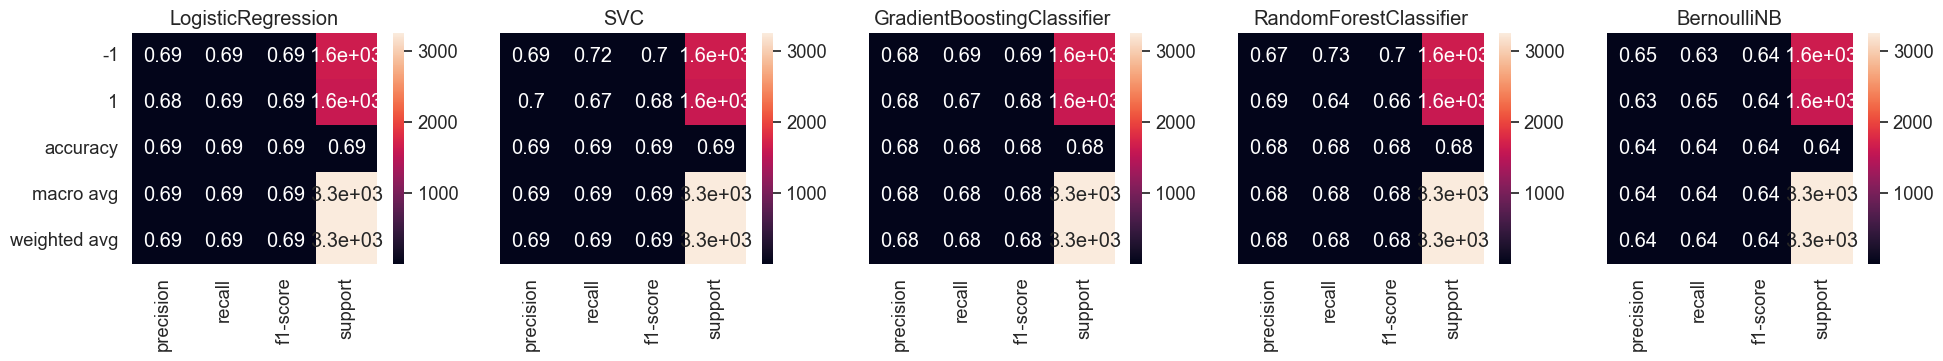

In [66]:
metrics_plot(classify_models, classify_names, 'classification_report')

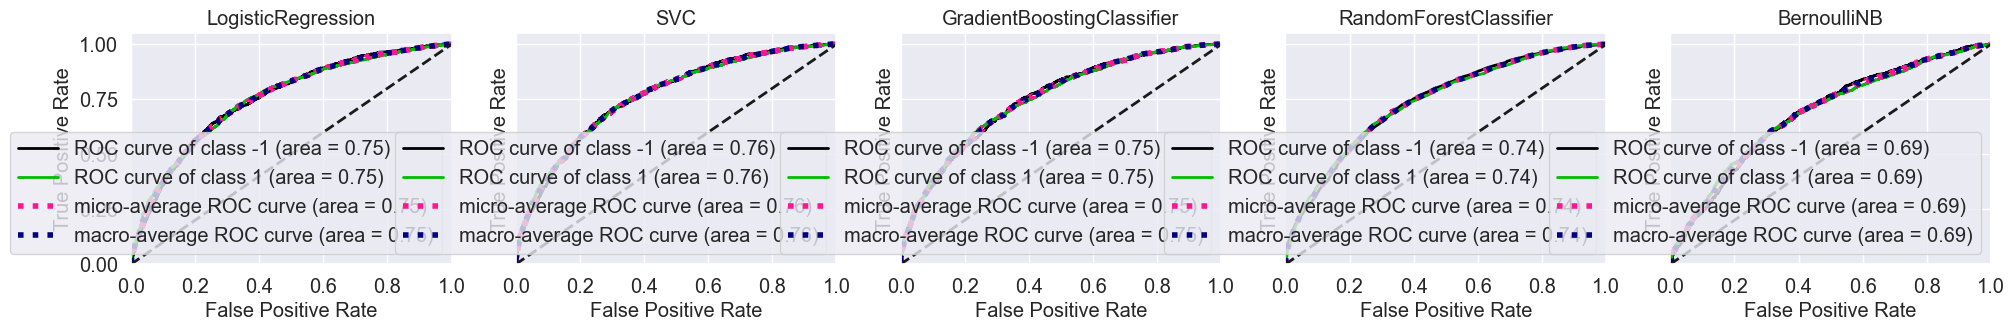

In [67]:
metrics_plot(classify_models, classify_names, 'roc-auc')

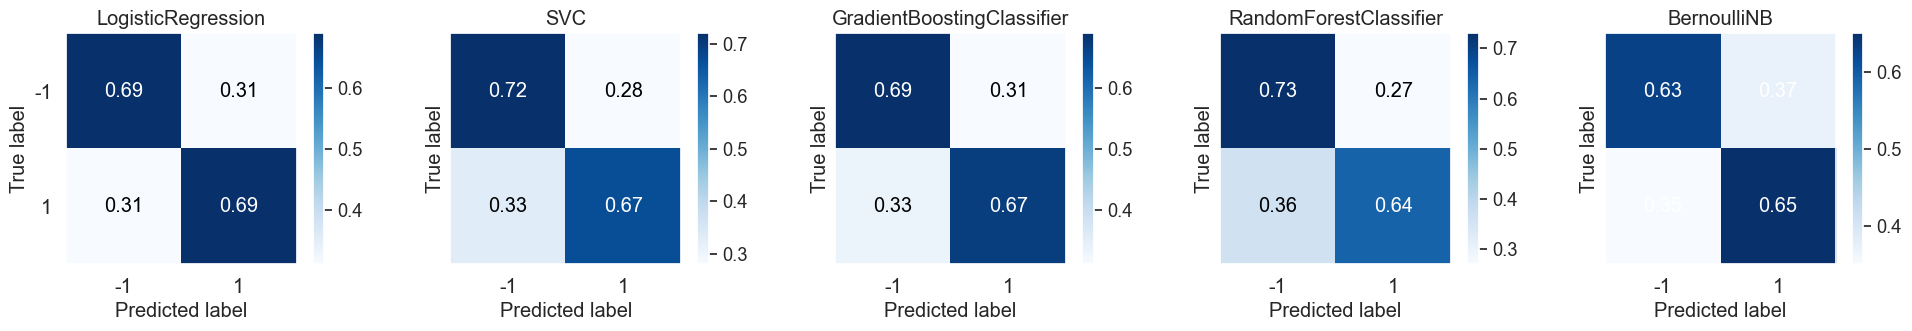

In [68]:
metrics_plot(classify_models, classify_names, 'confusion_matrix')

### Wav2Vec

Для кодирования аудио-данных использовались представления модели `Wav2Vec`, которая обучается посредством маскировки набора признаков для некоторых из *T* интервалов, и путем минимизации функции потерь модель на основе сверточных блоков учится подбирать наиболее похожий вектор, характеризующий признаки замаскированных участков, при этом модуль линейного слоя позволяет получить целевые вектора для замаскированных данных и таким образом модель обучается на размеченных данных.

In [69]:
audio = load_file('saved/wav2vec_v2_train.npy')
X_train, X_test, y_train, y_test = train_test_split(audio, audio_clf_df.sentiment_2, test_size=.2, random_state=2023)

In [70]:
classify_models, classify_names = models_fit(X_train, y_train)

LogisticRegression is fitted
SVC is fitted
GradientBoostingClassifier is fitted
RandomForestClassifier is fitted
BernoulliNB is fitted


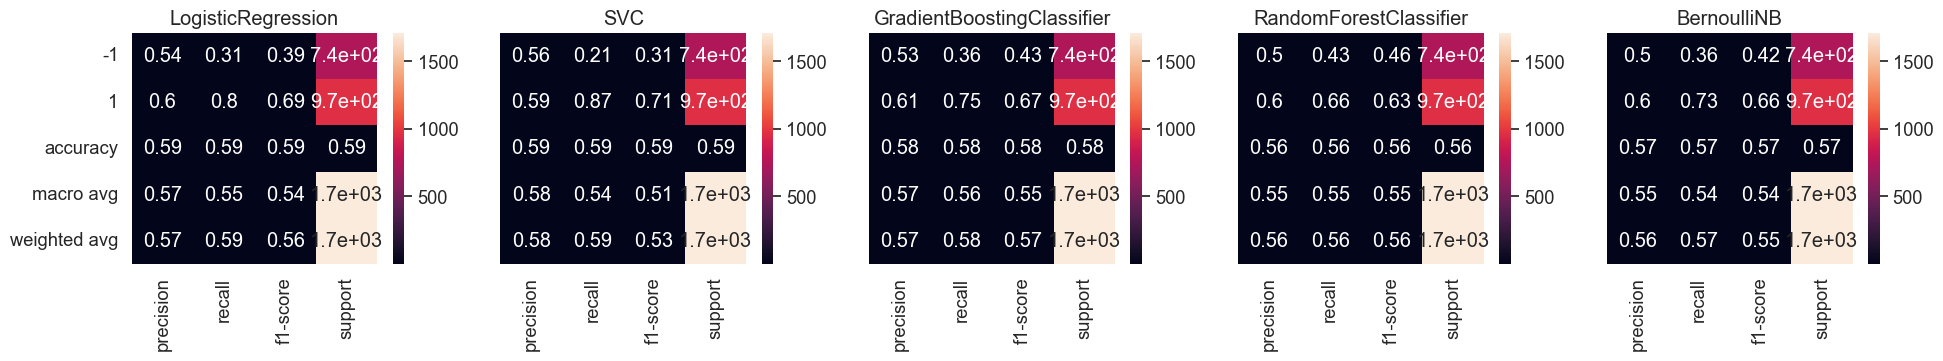

In [71]:
metrics_plot(classify_models, classify_names, 'classification_report')

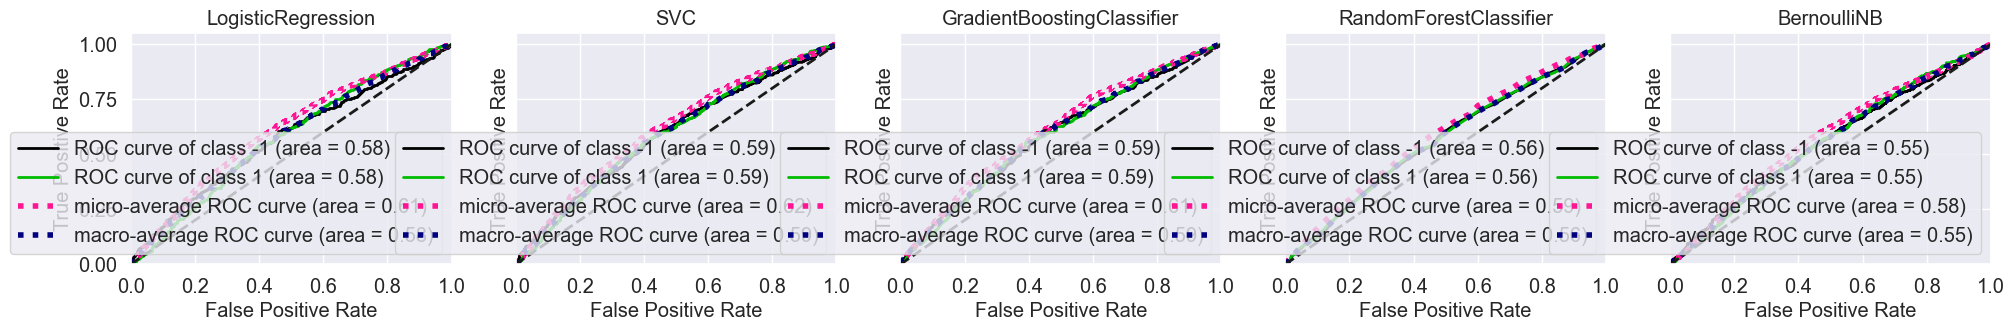

In [72]:
metrics_plot(classify_models, classify_names, 'roc-auc')

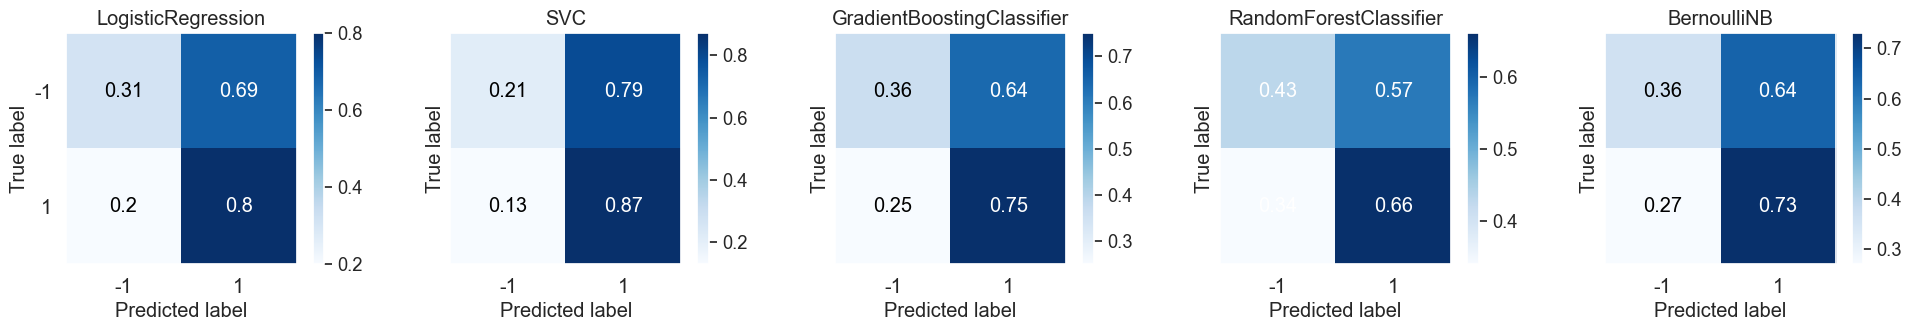

In [73]:
metrics_plot(classify_models, classify_names, 'confusion_matrix')

### BERT + Wav2Vec

In [74]:
audio_clf_df.sentiment_2.value_counts()

 1    4730
-1    3821
Name: sentiment_2, dtype: int64

In [85]:
data = np.concatenate([text[audio_clf_df.index], audio], axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, audio_clf_df.sentiment_2, test_size=.2, random_state=2023)

In [86]:
classify_models, classify_names = models_fit(X_train, y_train)

LogisticRegression is fitted
SVC is fitted
GradientBoostingClassifier is fitted
RandomForestClassifier is fitted
BernoulliNB is fitted


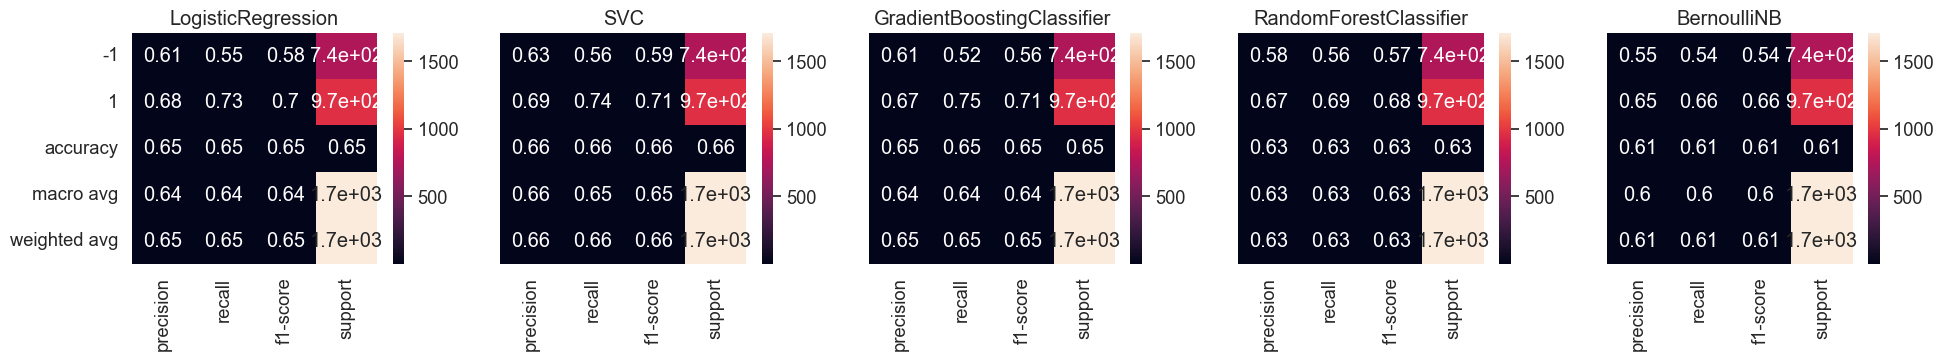

In [87]:
metrics_plot(classify_models, classify_names, 'classification_report')

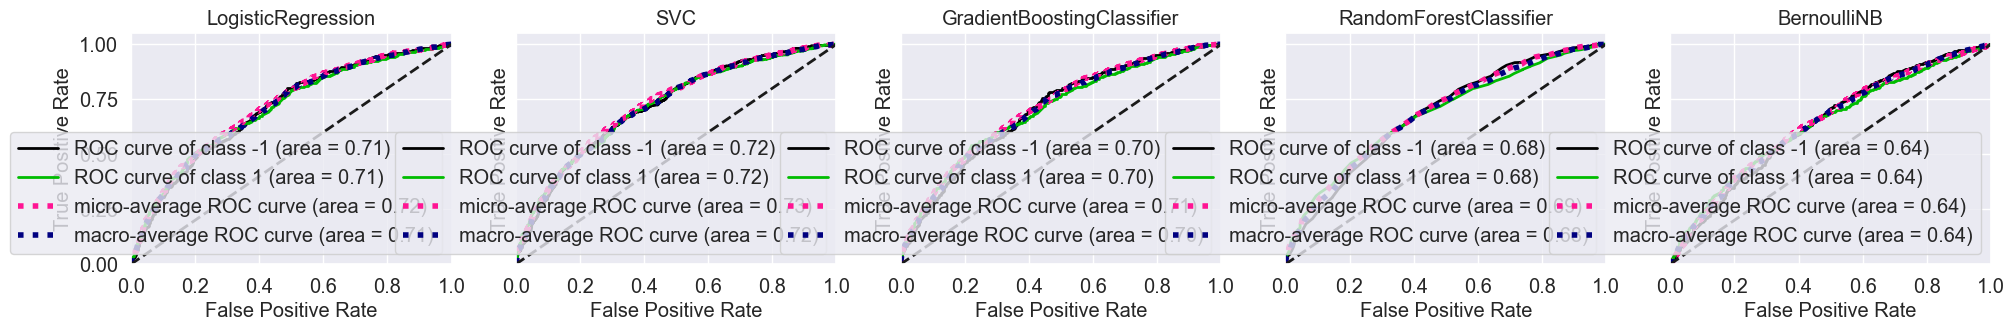

In [88]:
metrics_plot(classify_models, classify_names, 'roc-auc')

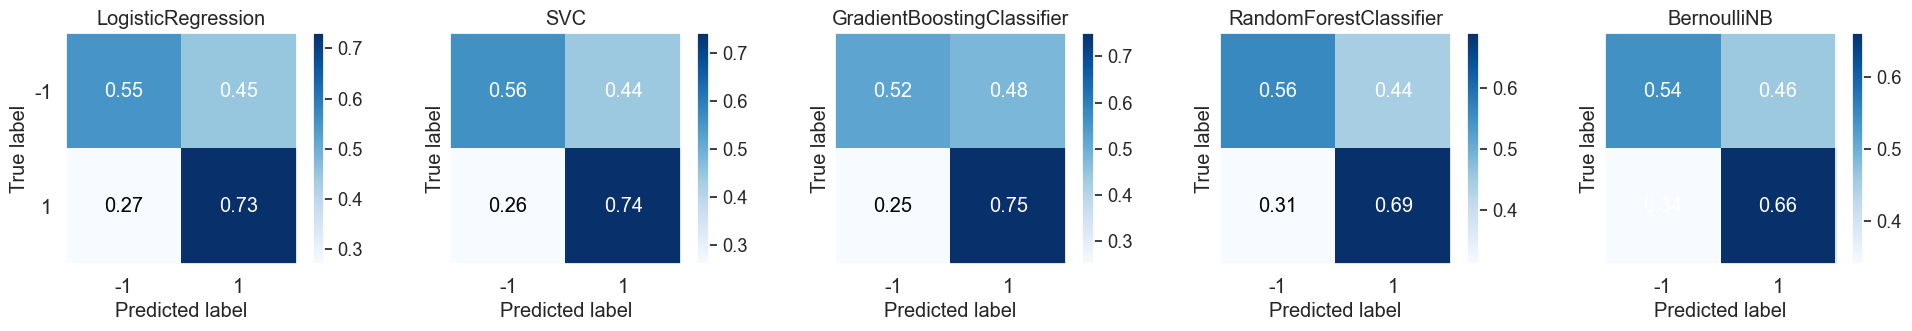

In [89]:
metrics_plot(classify_models, classify_names, 'confusion_matrix')

**Выводы**
- В ходе экспериментов было выявлено, что модель BERT показала лучшую производительность по сравнению с FastText, среди моделей наиболее отличились случайный лес и метод опорных векторов с нелинейным ядром
- Модель Wav2Vec показала производительность хуже, чем тектовые представления
- По результатам аналитического обзора было выявлено, что наибольший вклад в мультимодальную обработку сентимента вносит именно тектовая модальность, и это прежде всего связано с существованием больших предобученных языковых моделей, однако с приходом Wav2Vec возможно перевес может измениться в сторону аудио
- Использование модальности текст+аудио не дало повышения производительности

**Возможности дальнейшего улучшения**
- В качестве учебных целей модели BERT и Wav2Vec были выбраны крошечными, с небольшим число параметров, обученные с точностью почти до рандома. Для повышения производительности, следует использовать более большие предварительно обученные модели
- Следует выполнять Transfer-learning/Fine-Tuning моделй перед их использованием для получения максимально возможной производительности